In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tfs
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pickle
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut, cross_val_score

In [2]:
def show_images(imgs, size=(8, 8)):
    fig, ax = plt.subplots(figsize=(size[0]*2, size[1]*2))
    ax.set_xticks([])
    ax.set_yticks([])
    nmax = size[0] * size[1]
    ax.imshow(
        make_grid(imgs[:nmax], nrow=size[0]).permute(1, 2, 0)
    )

In [3]:
def show_history(history):
    plt.figure(figsize=(20, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, EPOCHS+1), history[0]['generator'], label='generator')
    plt.plot(range(1, EPOCHS+1), history[0]['discriminator'], label='discriminator')
    plt.legend(loc='lower right')
    plt.title('BCE Loss')

    plt.subplot(1, 2, 2)
    plt.plot(range(1, EPOCHS+1), history[1]['real'], label='real')
    plt.plot(range(1, EPOCHS+1), history[1]['fake'], label='fake')
    plt.legend(loc='upper left')
    plt.title('Accuracy')

    plt.show()

In [4]:
def generate(model, size):
    imgs = torch.Tensor()
    model.eval()
    with torch.no_grad():
        while size > 0:
            latent = torch.randn(
                min(size, BATCH_SIZE), LATENT_SIZE, 1, 1, device=DEVICE
            )
            imgs = torch.cat([imgs, model(latent).cpu()])
            size = size - BATCH_SIZE
    return imgs

# 1. Load data

In [5]:
DATA_DIR = '/kaggle/input/flickr-faces-70k-thumbnails-128x128/'
DATA_OUT = '/kaggle/input/gan-flickr-faces-output/'
#NORMS = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
BATCH_SIZE = 128
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
dataset = ImageFolder(DATA_DIR, transform=tfs.Compose([
    tfs.ToTensor(),
#    tfs.Normalize(*NORMS),
]))

dataloader = DataLoader(
    dataset, BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True
)

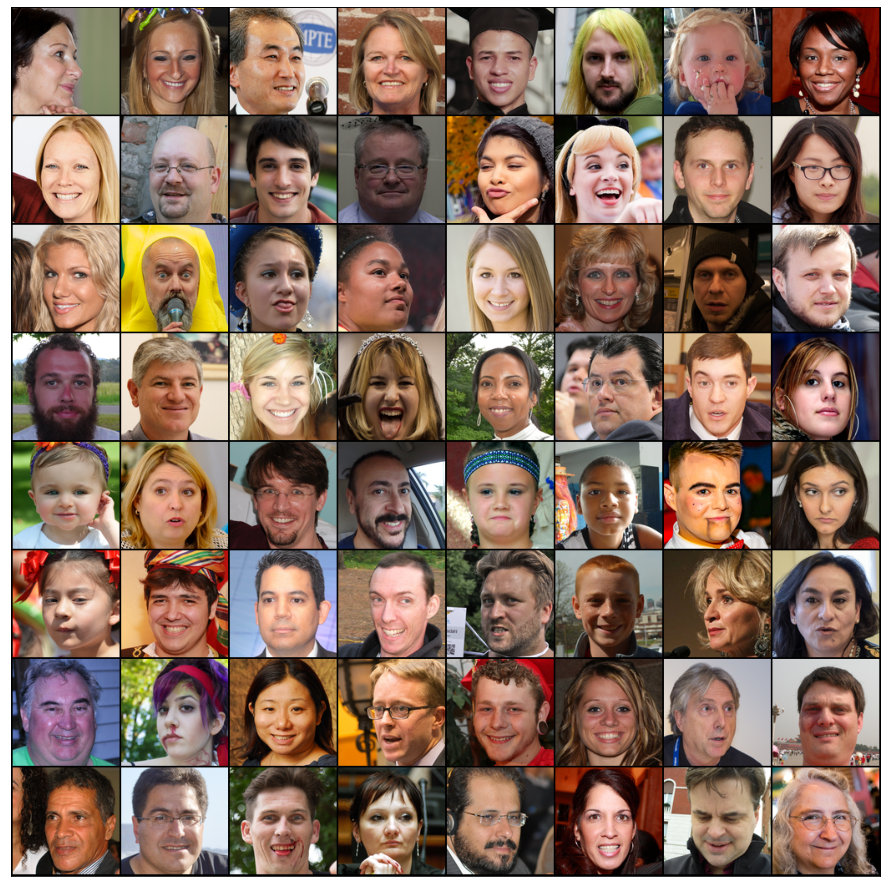

In [7]:
test_imgs, _ = next(iter(dataloader))
show_images(test_imgs)

# 2. Model

In [8]:
discriminator = nn.Sequential(
    # in: 3 x 128 x 128
    nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 32 x 64 x 64

    nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()

).to(DEVICE)

In [9]:
LATENT_SIZE = 128

In [10]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(LATENT_SIZE, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # nn.Dropout(0.5),
    # out: 1024 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # nn.Dropout(0.5),
    # out: 512 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # nn.Dropout(0.5),
    # out: 256 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # nn.Dropout(0.5),
    # out: 128 x 32 x 32

    nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.ReLU(True),
    # nn.Dropout(0.5),
    # out: 64 x 64 x 64

    # nn.ConvTranspose2d(64, 32, kernel_size=1, stride=1, padding=0, bias=False),
    # nn.BatchNorm2d(32),
    # nn.ReLU(True),
    
    nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 128 x 128

).to(DEVICE)    

In [11]:
LR = 0.0001

model = {
    'discriminator': discriminator,
    'generator': generator
}

criterion = {
    'discriminator': nn.BCELoss(),
    'generator': nn.BCELoss()
}

optimizer = {
    'discriminator': Adam(
        model['discriminator'].parameters(), lr=LR, betas=(0.5, 0.999)
    ),
    'generator': Adam(
        model['generator'].parameters(), lr=LR, betas=(0.5, 0.999)
    )
}

In [12]:
def fit(model, criterion, optimizer, epochs, save_results = False):
    # Losses & scores
    losses = {
        'discriminator': [],
        'generator': []
    }
    scores = {
        'real': [],
        'fake': []
    }

    for epoch in range(epochs):
        loss_per_epoch = {
            'discriminator': [],
            'generator': []
        }
        score_per_epoch = {
            'real': [],
            'fake': []
        }
        
        for real_images, _ in tqdm(dataloader):
            real_images = real_images.to(DEVICE)

            # Train discriminator

            # Clear discriminator gradients
            optimizer['discriminator'].zero_grad()
            
            # Pass real images through discriminator
            real_preds = model['discriminator'](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=DEVICE)
            real_loss = criterion['discriminator'](real_preds, real_targets)
            real_score = torch.mean(real_preds).item()
            
            # Generate fake images
            latent = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1, device=DEVICE)
            fake_images = model['generator'](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(BATCH_SIZE, 1, device=DEVICE)
            fake_preds = model['discriminator'](fake_images)
            fake_loss = criterion['discriminator'](fake_preds, fake_targets)
            fake_score = torch.mean(fake_preds).item()

            score_per_epoch['real'].append(real_score)
            score_per_epoch['fake'].append(fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer['discriminator'].step()
            loss_per_epoch['discriminator'].append(loss_d.item())

            # Train generator
            
            model['generator'].train()
            
            # Clear generator gradients
            optimizer['generator'].zero_grad()
            
            # Generate fake images
            latent = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1, device=DEVICE)
            fake_images = model['generator'](latent)
            
            # Try to fool the discriminator
            preds = model['discriminator'](fake_images)
            targets = torch.ones(BATCH_SIZE, 1, device=DEVICE)
            loss_g = criterion['generator'](preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer['generator'].step()
            loss_per_epoch['generator'].append(loss_g.item())
            
        # Record losses & scores
        losses['generator'].append(np.mean(loss_per_epoch['generator']))
        losses['discriminator'].append(np.mean(loss_per_epoch['discriminator']))
        scores['real'].append(np.mean(score_per_epoch['real']))
        scores['fake'].append(np.mean(score_per_epoch['fake']))
        
        # Log losses & scores (last batch)
        print(
            'Epoch [{}/{}], gen_loss: {:.4f}, dis_loss: {:.4f}, '
            'real_score: {:.4f}, fake_score: {:.4f}'.format(
                epoch+1, epochs, 
                losses['generator'][-1], losses['discriminator'][-1],
                scores['real'][-1], scores['fake'][-1]
            )
        )
        
        # Save results
        if save_results and ((epoch+1) in [1, 3, 8, 20, 50]):
            imgs = generate(model['generator'], 1000)
            with open(f'imgs_epoch_{epoch+1}.pkl', 'wb') as handle:
                pickle.dump(imgs, handle, protocol=pickle.HIGHEST_PROTOCOL)
            torch.save(
                model['generator'].state_dict(),
                f'gen_epoch_{epoch+1}.weights'
            )
            torch.save(
                model['discriminator'].state_dict(),
                f'dis_epoch_{epoch+1}.weights'
            )
    
    return losses, scores

In [13]:
EPOCHS = 50
history = fit(model, criterion, optimizer, EPOCHS, True)

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [1/50], gen_loss: 8.9514, dis_loss: 0.0900, real_score: 0.9798, fake_score: 0.0219


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [2/50], gen_loss: 5.4109, dis_loss: 0.1981, real_score: 0.9508, fake_score: 0.0461


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [3/50], gen_loss: 5.4354, dis_loss: 0.2890, real_score: 0.9117, fake_score: 0.0888


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [4/50], gen_loss: 4.8980, dis_loss: 0.4011, real_score: 0.8642, fake_score: 0.1337


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [5/50], gen_loss: 4.9152, dis_loss: 0.3534, real_score: 0.8729, fake_score: 0.1249


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [6/50], gen_loss: 5.0616, dis_loss: 0.3327, real_score: 0.8821, fake_score: 0.1155


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [7/50], gen_loss: 5.3184, dis_loss: 0.2965, real_score: 0.8938, fake_score: 0.1047


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [8/50], gen_loss: 5.2735, dis_loss: 0.2671, real_score: 0.9042, fake_score: 0.0944


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [9/50], gen_loss: 5.6105, dis_loss: 0.2712, real_score: 0.9073, fake_score: 0.0920


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [10/50], gen_loss: 5.4336, dis_loss: 0.2640, real_score: 0.9095, fake_score: 0.0894


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [11/50], gen_loss: 5.3551, dis_loss: 0.2637, real_score: 0.9093, fake_score: 0.0893


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [12/50], gen_loss: 5.3125, dis_loss: 0.2627, real_score: 0.9085, fake_score: 0.0911


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [13/50], gen_loss: 4.8252, dis_loss: 0.2835, real_score: 0.9042, fake_score: 0.0950


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [14/50], gen_loss: 4.5897, dis_loss: 0.2873, real_score: 0.8991, fake_score: 0.1002


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [15/50], gen_loss: 4.3001, dis_loss: 0.3175, real_score: 0.8976, fake_score: 0.1023


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [16/50], gen_loss: 4.2863, dis_loss: 0.3158, real_score: 0.8937, fake_score: 0.1066


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [17/50], gen_loss: 4.3383, dis_loss: 0.2999, real_score: 0.8957, fake_score: 0.1036


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [18/50], gen_loss: 4.3010, dis_loss: 0.3161, real_score: 0.8946, fake_score: 0.1055


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [19/50], gen_loss: 4.1285, dis_loss: 0.2776, real_score: 0.9008, fake_score: 0.0985


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [20/50], gen_loss: 4.2726, dis_loss: 0.3067, real_score: 0.8975, fake_score: 0.1025


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [21/50], gen_loss: 4.1409, dis_loss: 0.3137, real_score: 0.8980, fake_score: 0.1015


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [22/50], gen_loss: 4.2446, dis_loss: 0.2892, real_score: 0.9067, fake_score: 0.0934


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [23/50], gen_loss: 4.2930, dis_loss: 0.2522, real_score: 0.9124, fake_score: 0.0877


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [24/50], gen_loss: 4.2642, dis_loss: 0.2837, real_score: 0.9091, fake_score: 0.0907


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [25/50], gen_loss: 4.3866, dis_loss: 0.2427, real_score: 0.9171, fake_score: 0.0829


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [26/50], gen_loss: 4.4079, dis_loss: 0.2577, real_score: 0.9154, fake_score: 0.0843


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [27/50], gen_loss: 4.4698, dis_loss: 0.2210, real_score: 0.9256, fake_score: 0.0743


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [28/50], gen_loss: 4.6247, dis_loss: 0.2529, real_score: 0.9265, fake_score: 0.0735


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [29/50], gen_loss: 4.5817, dis_loss: 0.2238, real_score: 0.9257, fake_score: 0.0743


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [30/50], gen_loss: 4.6230, dis_loss: 0.2832, real_score: 0.9180, fake_score: 0.0810


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [31/50], gen_loss: 4.6274, dis_loss: 0.2494, real_score: 0.9248, fake_score: 0.0759


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [32/50], gen_loss: 4.7323, dis_loss: 0.1892, real_score: 0.9342, fake_score: 0.0659


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [33/50], gen_loss: 4.6436, dis_loss: 0.2555, real_score: 0.9228, fake_score: 0.0770


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [34/50], gen_loss: 4.7640, dis_loss: 0.2289, real_score: 0.9278, fake_score: 0.0721


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [35/50], gen_loss: 4.7905, dis_loss: 0.2197, real_score: 0.9299, fake_score: 0.0701


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [36/50], gen_loss: 4.8854, dis_loss: 0.1844, real_score: 0.9380, fake_score: 0.0617


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [37/50], gen_loss: 4.6997, dis_loss: 0.2236, real_score: 0.9382, fake_score: 0.0621


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [38/50], gen_loss: 4.9971, dis_loss: 0.2247, real_score: 0.9348, fake_score: 0.0650


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [39/50], gen_loss: 4.9971, dis_loss: 0.1910, real_score: 0.9406, fake_score: 0.0594


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [40/50], gen_loss: 5.0417, dis_loss: 0.2026, real_score: 0.9351, fake_score: 0.0649


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [41/50], gen_loss: 4.9811, dis_loss: 0.2249, real_score: 0.9365, fake_score: 0.0635


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [42/50], gen_loss: 4.9467, dis_loss: 0.1696, real_score: 0.9507, fake_score: 0.0493


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [43/50], gen_loss: 5.1570, dis_loss: 0.2197, real_score: 0.9307, fake_score: 0.0693


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [44/50], gen_loss: 5.0800, dis_loss: 0.1634, real_score: 0.9493, fake_score: 0.0504


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [45/50], gen_loss: 5.1369, dis_loss: 0.2045, real_score: 0.9408, fake_score: 0.0592


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [46/50], gen_loss: 5.2219, dis_loss: 0.1711, real_score: 0.9443, fake_score: 0.0557


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [47/50], gen_loss: 5.1570, dis_loss: 0.1507, real_score: 0.9505, fake_score: 0.0494


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [48/50], gen_loss: 5.1326, dis_loss: 0.2634, real_score: 0.9334, fake_score: 0.0665


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [49/50], gen_loss: 5.1241, dis_loss: 0.1579, real_score: 0.9482, fake_score: 0.0521


  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [50/50], gen_loss: 5.1573, dis_loss: 0.2094, real_score: 0.9401, fake_score: 0.0597


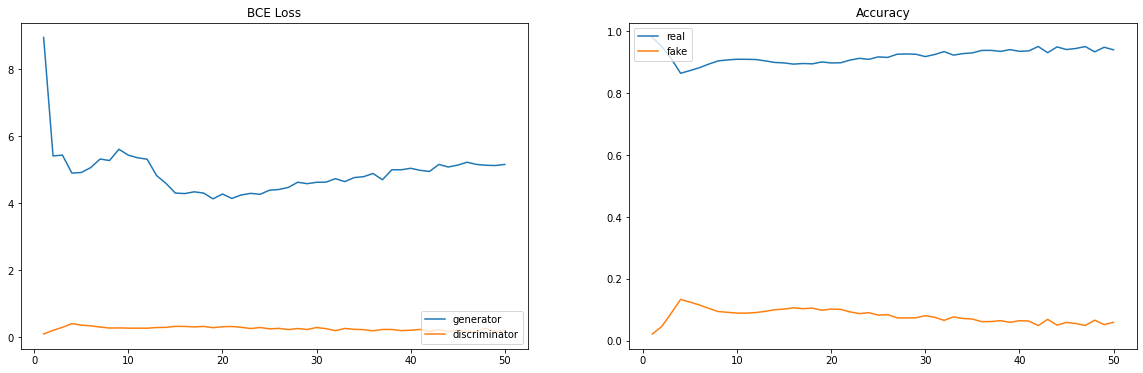

In [14]:
# with open('history.pkl', 'wb') as handle:
#     pickle.dump(history, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open(DATA_OUT + 'history.pkl', 'rb') as handle:
#     history = pickle.load(handle)
show_history(history)

# 3. Sample

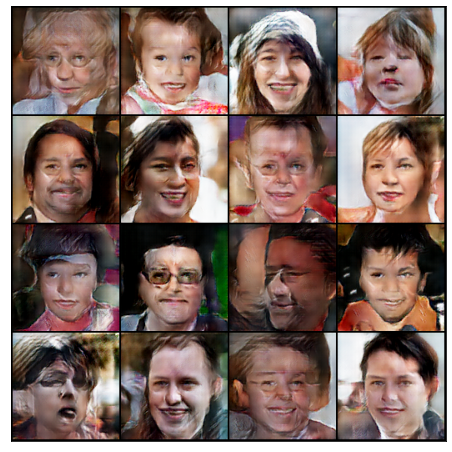

In [15]:
N_IMAGES = 16
show_images(generate(model['generator'], N_IMAGES), size=(4, 4))

# 5. Visualization
Сделал сначала визуализацию, так проще понять accuracy после knn

In [16]:
N_IMAGES = 1000

real_imgs = torch.Tensor()
for imgs, _ in dataloader:
    real_imgs = torch.cat([real_imgs, imgs])
    if real_imgs.shape[0] >= N_IMAGES:
        break

Посмотрим на распределение настоящих и фейковых изображений после t-SNE после 1, 3, 8, 20 и 50 эпохи

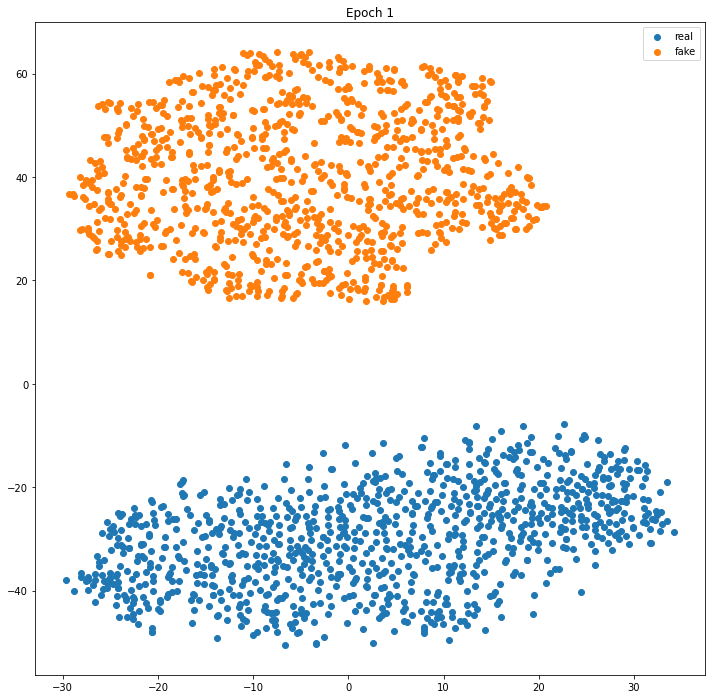

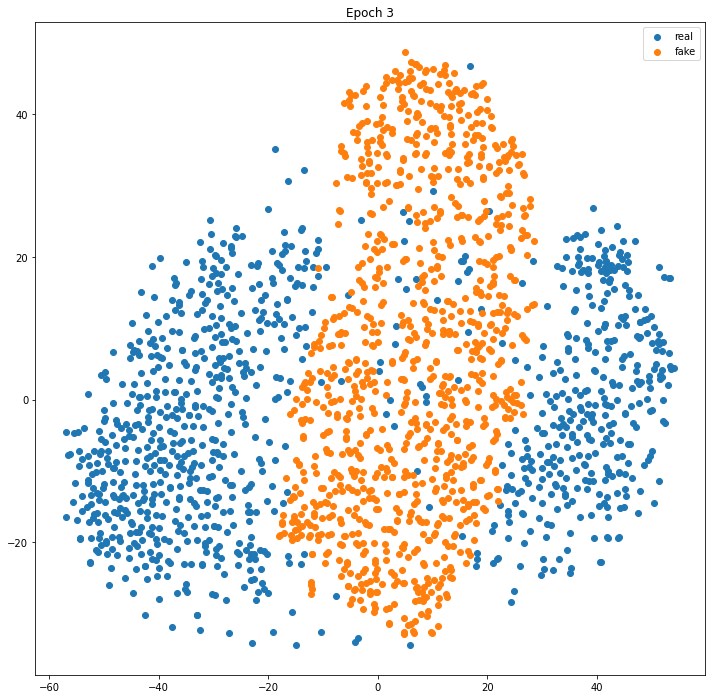

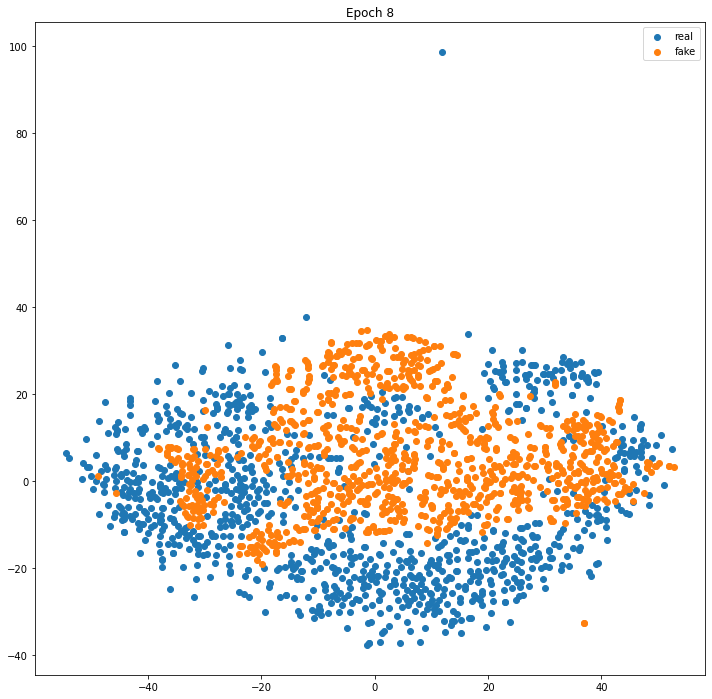

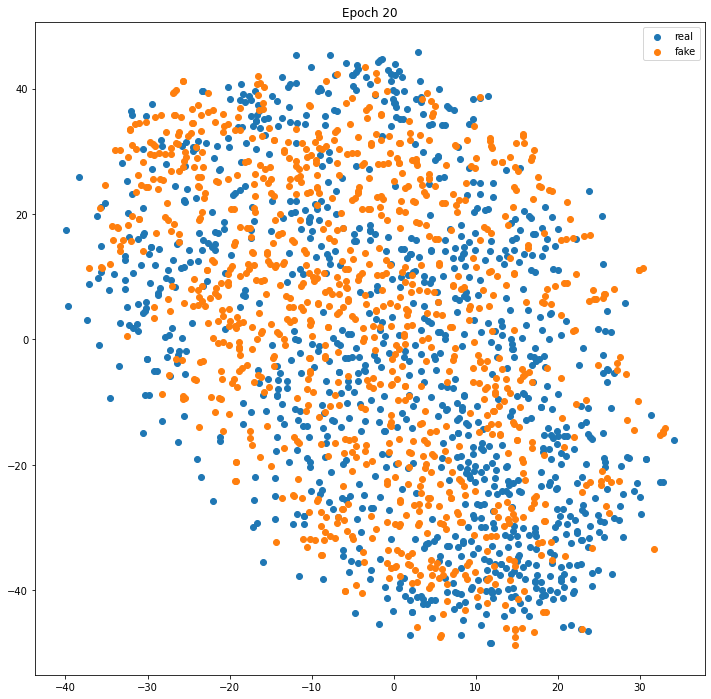

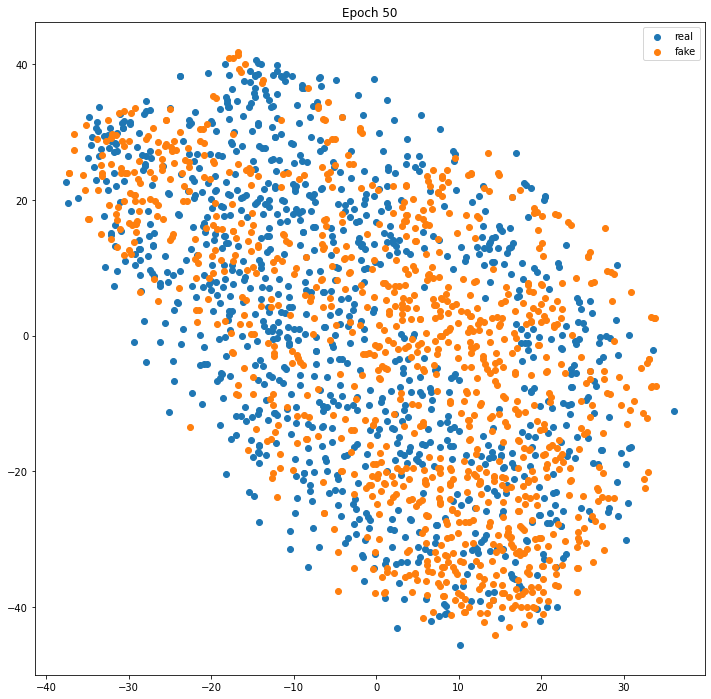

In [17]:
# t-SNE presentation
ts_data = {}
for epoch in [1, 3, 8, 20, 50]:
    with open(f'imgs_epoch_{epoch}.pkl', 'rb') as handle:
        fake_imgs = pickle.load(handle)
    
    imgs_flatten = torch.cat([
        real_imgs.flatten(start_dim=1)[:N_IMAGES, :],
        fake_imgs.flatten(start_dim=1)[:N_IMAGES, :]
    ])
    
    ts = TSNE(random_state=42, verbose=0).fit_transform(imgs_flatten)

    fig, ax = plt.subplots(figsize=(12, 12))
    plt.title(f'Epoch {epoch}')
    plt.scatter(ts[:N_IMAGES, 0], ts[:N_IMAGES, 1], label='real')
    plt.scatter(ts[N_IMAGES:, 0], ts[N_IMAGES:, 1], label='fake')
    plt.legend()
    
    ts_data[epoch] = ts

Чем ближе форма сгенерированного распределения к реальному, тем лучше генерация. При идеальной генерации облака точек будут совпадать, разделить их на два класса не получается, accuracy равно 0.5

# 4. Leave-one-out-1-NN classifier accuracy

Проверим, аккураси должно стремиться от 1 (отличаются полностью, легко разделить на 2 класса) к 0.5 (соседом может быть одинаково вероятно как реальное изображение, так и сгенерированное).

In [18]:
labels = torch.cat([torch.ones(N_IMAGES), torch.zeros(N_IMAGES)])

# build model
model = KNeighborsClassifier(n_neighbors=1)

# define cross-validation method to use
cv = LeaveOneOut()

for epoch in [1, 3, 8, 20, 50]:
    # use LOOCV to evaluate model
    accuracies = cross_val_score(
        model, ts_data[epoch], labels, scoring='accuracy', cv=cv, n_jobs=-1
    )
    print(f'Epoch {epoch} mean accuracy: {accuracies.mean()}')

Epoch 1 mean accuracy: 1.0
Epoch 3 mean accuracy: 0.9715
Epoch 8 mean accuracy: 0.925
Epoch 20 mean accuracy: 0.7435
Epoch 50 mean accuracy: 0.7435
